# Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
import datetime

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load & Clean the Data

In [2]:
df = pd.read_csv("loan.csv", low_memory = False)

In [3]:
df.shape

(887379, 74)

In [4]:
df.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51457
emp_length                          0
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761350
purpose                             0
title                             151
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

In [5]:
df.drop('id',1,inplace=True)
df.drop('url',1,inplace=True)
df.drop('desc',1,inplace=True)
df.drop('policy_code',1,inplace=True)
## rather than drop these should we coalesce with their individual counterparts?
df.drop('annual_inc_joint',1,inplace=True)
df.drop('dti_joint',1,inplace=True)
df.drop('verification_status_joint',1,inplace=True)
df.drop('open_acc_6m',1,inplace=True)
df.drop('open_il_6m',1,inplace=True)
df.drop('open_il_12m',1,inplace=True)
df.drop('open_il_24m',1,inplace=True)
df.drop('mths_since_rcnt_il',1,inplace=True)
df.drop('total_bal_il',1,inplace=True)
df.drop('il_util',1,inplace=True)
df.drop('open_rv_12m',1,inplace=True)
df.drop('open_rv_24m',1,inplace=True)
df.drop('max_bal_bc',1,inplace=True)
df.drop('all_util',1,inplace=True)
df.drop('inq_fi',1,inplace=True)
df.drop('total_cu_tl',1,inplace=True)
df.drop('inq_last_12m',1,inplace=True)
df = df.dropna(axis=0,how='all')

In [6]:
df.dtypes

member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq   

In [7]:
df.term = pd.Categorical(df.term)
df.grade = pd.Categorical(df.grade)
df.sub_grade = pd.Categorical(df.sub_grade)
df.issue_d = pd.to_datetime(df.issue_d)
df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d)
df.next_pymnt_d = pd.to_datetime(df.next_pymnt_d)
df.last_credit_pull_d = pd.to_datetime(df.last_credit_pull_d)

#df.loan_status = pd.Categorical(df.loan_status)
#df.loan_amnt = np.float64(df.loan_amnt)
#df.annual_inc = np.float64(df.annual_inc)
#df.int_rate = np.float64(df.int_rate)
#df.total_rec_late_fee = np.float64(df.total_rec_late_fee)
#df.dti = np.float64(df.dti)

# Data Exploration and Evaluation

In [8]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,...,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,221703.000000,887350.000000,8.171030e+05,8.171030e+05,8.171030e+05
mean,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,...,0.396692,45.919243,4.880757,2164.145585,0.014380,44.104838,0.004991,2.257026e+02,1.394582e+05,3.206862e+04
std,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,...,4.087825,409.693874,63.125281,4794.783233,0.134191,22.179841,0.077625,1.031137e+04,1.537500e+05,3.749826e+04
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,...,0.000000,0.000000,0.000000,280.170000,0.000000,27.000000,0.000000,0.000000e+00,2.985300e+04,1.390000e+04
50%,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,...,0.000000,0.000000,0.000000,462.780000,0.000000,44.000000,0.000000,0.000000e+00,8.055900e+04,2.370000e+04
75%,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,1.000000,...,0.000000,0.000000,0.000000,831.245000,0.000000,61.000000,0.000000,0.000000e+00,2.082050e+05,3.980000e+04
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,33.000000,...,358.680000,33520.270000,7002.190000,36475.590000,20.000000,188.000000,14.000000,9.152545e+06,8.000078e+06,9.999999e+06


Loan Grade looks like an important categorical variable.  It may be helpful to segment the data on loan grade to look at variance in the other features.

In [9]:
df.groupby('grade').mean()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
grade,,,,,,,,,,,,,,,,,,,,,
A,3.566786e+07,14038.860306,14023.323572,14000.506187,7.243312,427.599175,86942.651653,15.577401,0.185855,0.403371,...,0.152201,9.378404,0.980114,1873.275944,0.007451,44.407401,0.001019,145.751879,175212.608630,47014.290774
B,3.412796e+07,13642.965211,13630.195062,13594.642917,10.829618,408.439291,75487.389207,17.305115,0.308154,0.550598,...,0.269834,24.562364,2.452875,1991.736000,0.014114,43.842260,0.003917,234.600429,140857.779778,32701.382733
C,3.603620e+07,14466.306028,14458.230599,14423.251934,13.980098,421.942081,71536.950300,18.792559,0.349268,0.742774,...,0.387997,39.839245,4.318221,2094.619938,0.016328,44.296719,0.006020,262.137648,130433.970897,28450.268219
D,3.410816e+07,15459.506278,15450.499670,15405.780441,17.175814,455.570227,69169.272616,19.908175,0.361815,0.905060,...,0.569861,68.525247,7.450313,2324.333194,0.016907,44.114723,0.007102,229.658687,123982.931388,26206.514839
E,3.611530e+07,17998.146171,17970.831978,17907.977084,19.897322,514.993641,72119.152229,20.338847,0.365156,1.005148,...,0.729501,110.444238,11.645686,2764.295556,0.017217,44.102423,0.007934,216.872920,129624.773287,26849.450016
F,3.230813e+07,19139.160809,19098.808904,19005.420917,23.582787,565.654337,73801.170917,19.834316,0.370607,1.221861,...,1.045983,198.265825,20.637929,3442.141559,0.015976,43.757030,0.007854,233.355843,128339.932044,25489.949626
G,3.089610e+07,20538.563491,20497.959555,20296.247792,25.626706,627.054815,79904.591762,19.182093,0.424303,1.516305,...,1.854548,249.712500,29.357835,3957.935711,0.018971,43.060361,0.012388,208.200248,129797.600538,25553.756678


Interest rate and loan size both increase with grade. Additionally many other features, especially those relating to credit scoring, follow a general trend with respect to loan grades. 

Let's see how many of each of these loans are represented in the dataset:

B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64


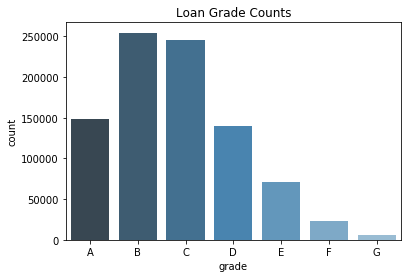

In [10]:
LoanGradeCounts = df.grade.value_counts()
print (LoanGradeCounts)

sns.countplot(x="grade", data=df, palette="Blues_d").set_title('Loan Grade Counts')
plt.savefig('LoanGradeHist')

In [11]:
print ("The average interest rate across all loans is ", df.int_rate.mean())
interest = df['int_rate']
print ("The standard deviation of the interst rates is", np.std(interest))

The average interest rate across all loans is  13.246739679476775
The standard deviation of the interst rates is 4.38186494572658


Mid to low risk loans seem to be favored over more high-risk and subprime loans.  B and C Grade loans seem to be the most common, driving the average interest rate down to 13.25 % across all loans.

Given the variability in loans, it may be helpful to understand what professions are most commonly seeking Lending Club loans.  Although the employment field is a free form variable and therefore doesn't have the cleanest data, it still may be useful to see the most frequently entered job titles for these loans:

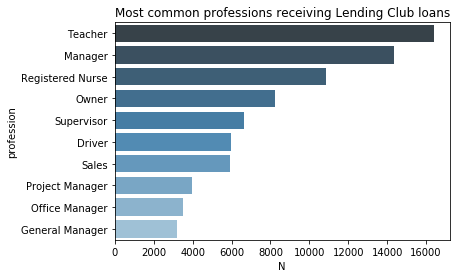

In [12]:
for i in range (0,887379):
    if df.loc[i, 'emp_title'] == 'teacher':
        df.loc[i, 'emp_title'] = 'Teacher'
    elif df.loc[i, 'emp_title'] == 'manager':
        df.loc[i, 'emp_title'] = 'Manager'
    elif df.loc[i, 'emp_title'] == 'RN':
        df.loc[i, 'emp_title'] = 'Registered Nurse'
    elif df.loc[i, 'emp_title'] == 'owner':
        df.loc[i, 'emp_title'] = 'Owner'
    elif df.loc[i, 'emp_title'] == 'driver':
        df.loc[i, 'emp_title'] = 'Driver'
    elif df.loc[i, 'emp_title'] == 'sales':
        df.loc[i, 'emp_title'] = 'Sales'    
    elif df.loc[i, 'emp_title'] == 'supervisor':
        df.loc[i, 'emp_title'] = 'Supervisor'   

        
emp = pd.DataFrame(Counter(df.emp_title).most_common(11), columns=['profession', 'N'])
emp = emp[(emp.profession.isnull() == False)]

sns.barplot(data=emp, y = 'profession', x='N', palette="Blues_d")
plt.title('Most common professions receiving Lending Club loans', loc='left')
plt.savefig('ProfessionHist')

In [13]:
df.annual_inc.mean()

75027.58776076681

Because this dataset contains several years of history during which legislation regarding consumer loans and LC's prominence changed significantly, it would be interesting to see how our variables trend over time.

The field issue_d contains the month and year during which the loan originated. 

First, we can see how the number of loans has grown over time:

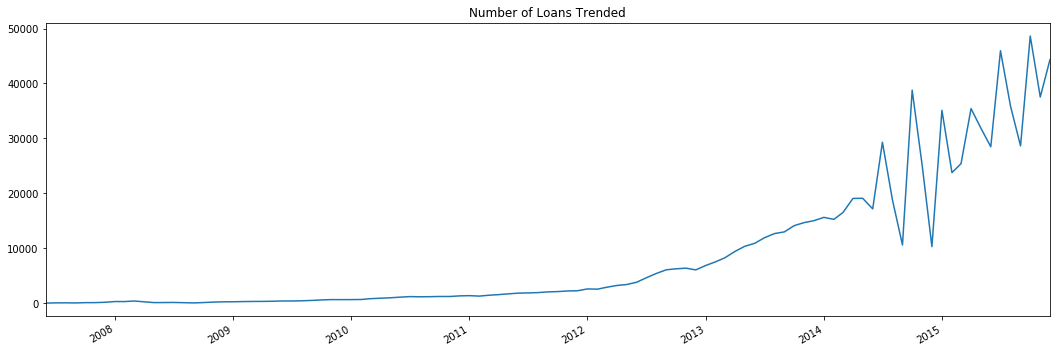

In [14]:
MonthlyLoans = df.issue_d.value_counts()
ax = MonthlyLoans.plot(title="Number of Loans Trended", figsize=(18,6))
plt.savefig('LoansTrended')

That's a pretty sharp increase and while the trend line starts quite smooth, it becomes pretty jagged in mid-2014. There may be several reasons for this.

Did LC change their presence in certain lending markets over others causing the general increase?  Furthermore, did the fluctuations in loans happen uniformly across all grades? 

It might be helpful to trend the number of loans per loan grade to find out.

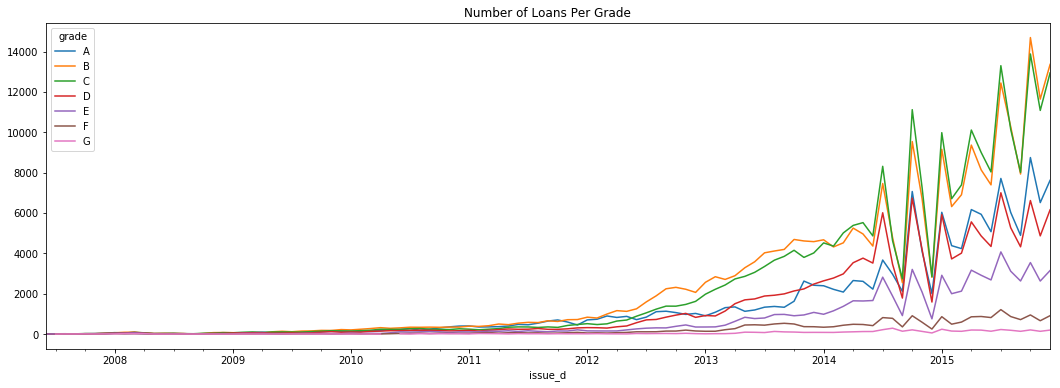

In [15]:
#Number of Loans by Grade and Date

loansByGrade = df.groupby(["grade","issue_d"])
byGradeLoans = loansByGrade.size()
byGradeLoans

unstackedbyGradeLoans = byGradeLoans.unstack(level=0)
#stackedbyGradeLoans = unstackedbyGradeLoans.stack(level=0)

unstackedbyGradeLoans.plot(title = "Number of Loans Per Grade", figsize=(18,6))
plt.savefig('LoansByGradeTrended')

A less cluttered version:

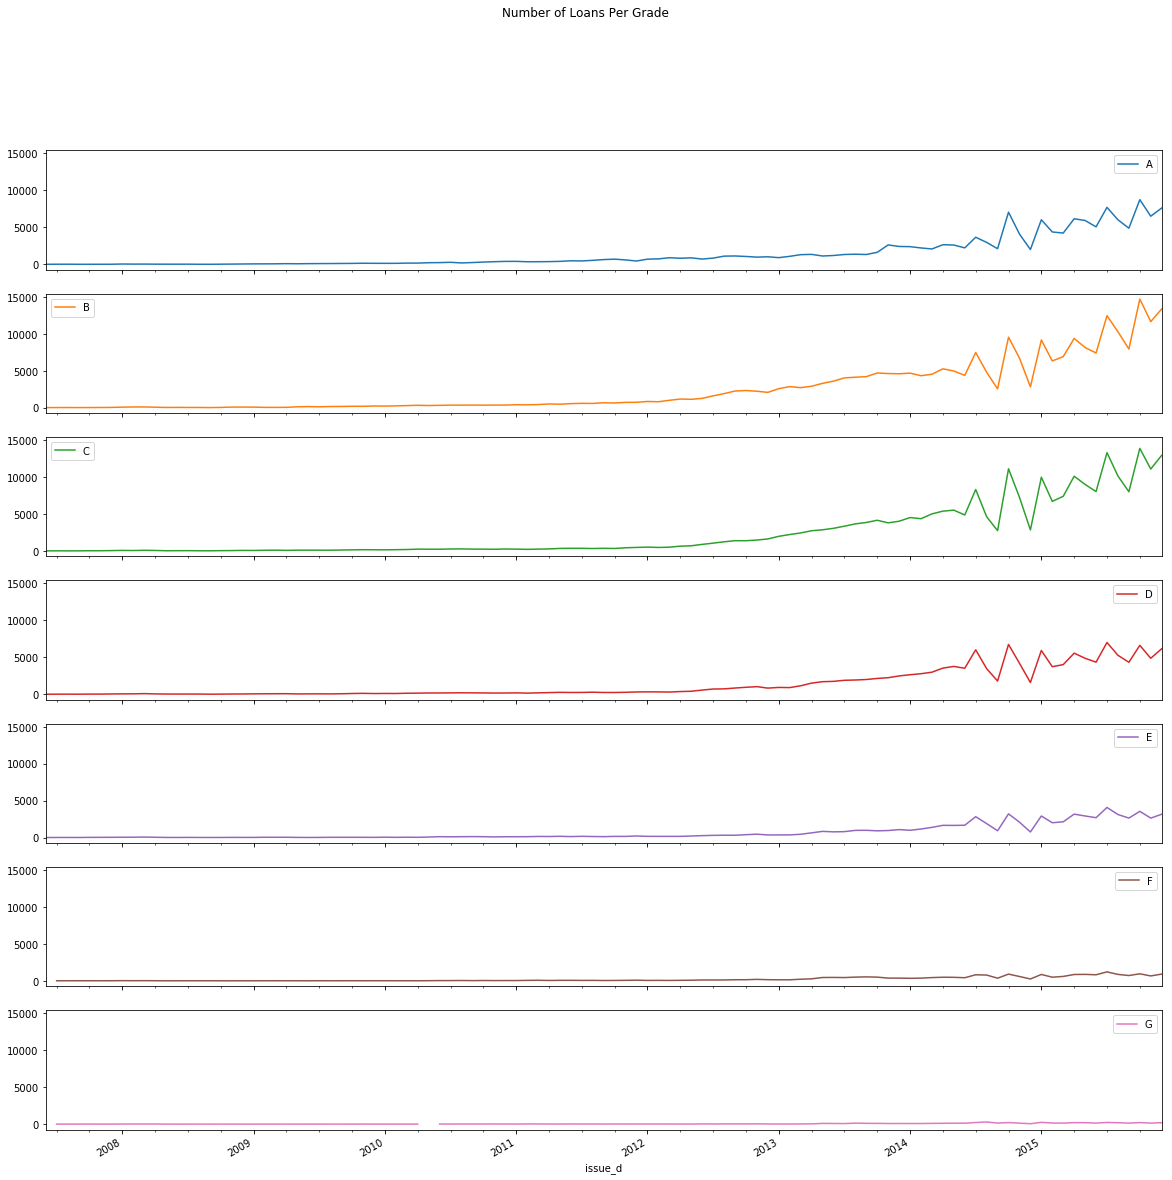

In [16]:
unstackedbyGradeLoans.plot(title = "Number of Loans Per Grade", subplots = True, figsize = (20,20), layout = (7,1), sharey = True)
plt.savefig('LoansByGradeSubplots')

 The largest increase in the number of loans comes from the B and C grades which rose sharply beginning in 2013. The fluctuations in 2014 and 2015 appear to be uniform across all loan grades, suggesting a larger company-wide or market influence.

What about the size of loans? As LC became a larger player in the consumer lending market, did they also begin to make larger loans on average?  Since the increase in the number of loans comes from lower risk segments and we saw that low risk segments tend to have smaller loan sizes, we may guess that the average loan amount decreases over time.

We can trend the average loan size over time to find out.

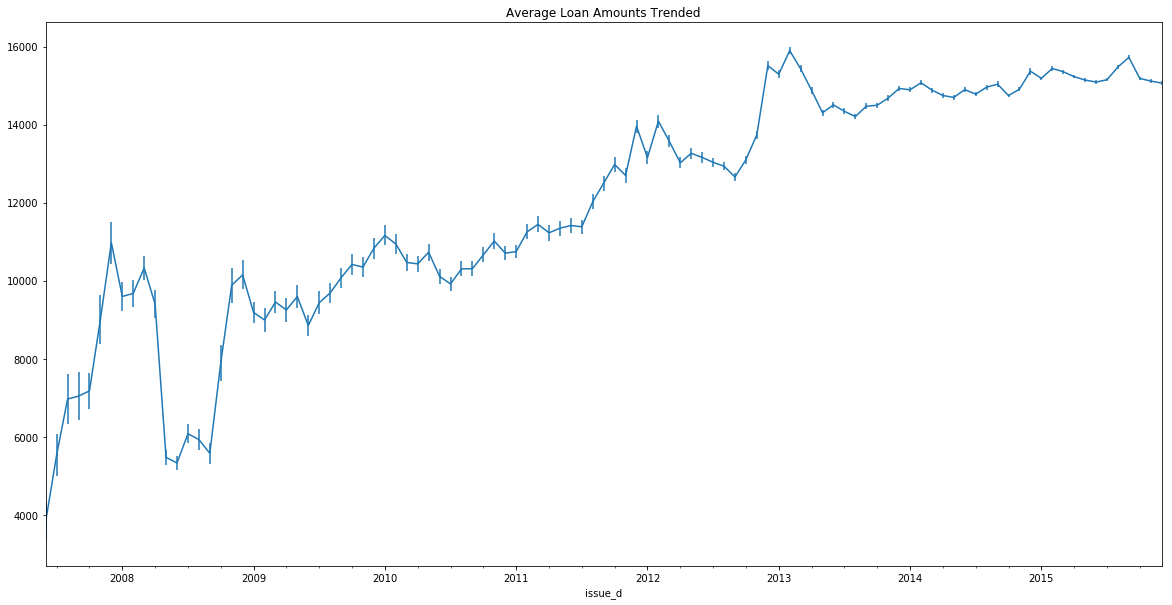

In [17]:
LoansByDate = df.groupby("issue_d")


LoanMeans = LoansByDate["loan_amnt"].agg(np.mean)
LoanErrs = LoansByDate["loan_amnt"].agg(stats.sem)


LoanMeans.plot(yerr=LoanErrs, title = "Average Loan Amounts Trended", figsize = (20,10))

#ax = LoanMeans.plot(title = "Average Loan Amount Trended, but prettier")
#ax.fill_between(x=LoanMeans.index, y1=LoanMeans-LoanErrs, y2=LoanMeans+LoanErrs, color='y', alpha=0.7)

plt.savefig('AvgLoanSizeTrended')

Our hypothesis doesn't seem to hold up; the average size of loans increased over time.  

Again, did the increase happen uniformly across all loan grades or did certain segments increase more quickly than others?

In [18]:
ByGradeLoanMeans = loansByGrade["loan_amnt"].agg(np.mean)
ByGradeLoanErrs = loansByGrade["loan_amnt"].agg(stats.sem)

In [19]:
unstackedByGradeLoanMeans = ByGradeLoanMeans.unstack(level=0)
unstackedByGradeLoanErrs = ByGradeLoanErrs.unstack(level=0)

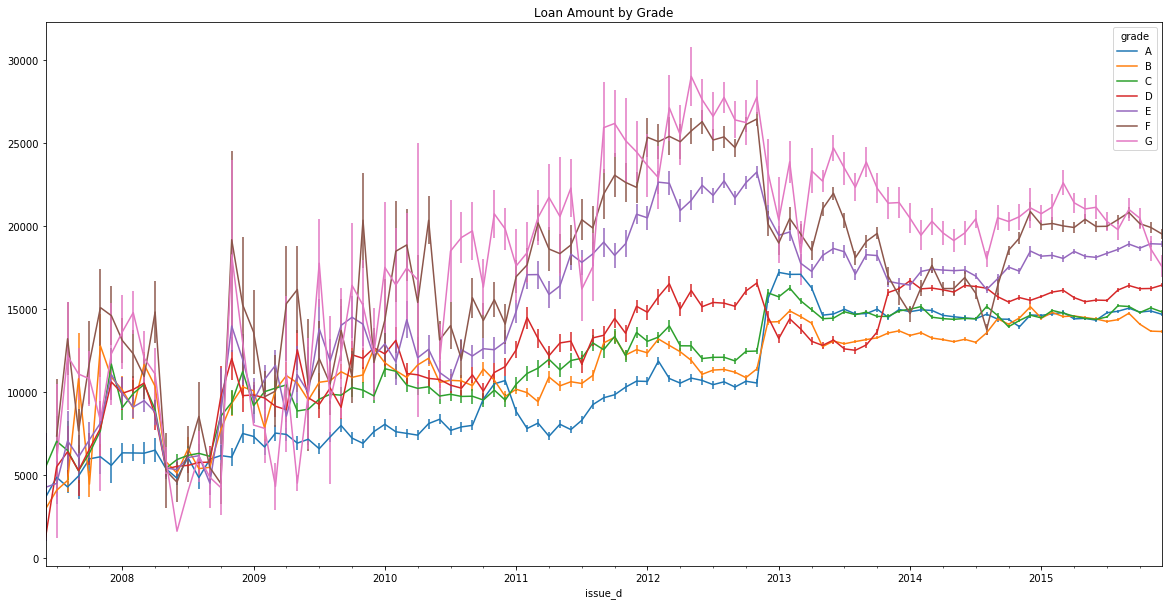

In [20]:
unstackedByGradeLoanMeans.plot(yerr = unstackedByGradeLoanErrs, title = "Loan Amount by Grade", figsize = (20,10))
plt.savefig('AvgLoanSizeByGradeTrended')

The unstacked version:

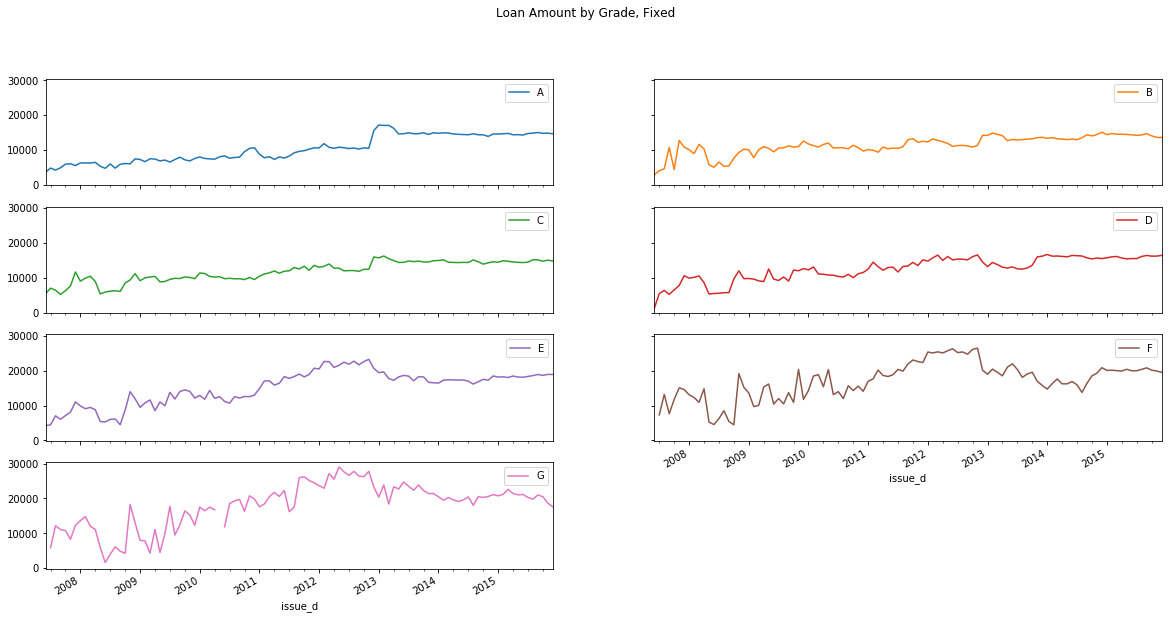

In [21]:
unstackedByGradeLoanMeans.plot(title = "Loan Amount by Grade, Fixed"
                                    ,subplots = True, figsize = (20,10), layout=(4,2), sharey = True)
plt.savefig('AvgLoanSizeByGradeSubplots')

Because we are ultimately interested in returns, we might also want to take a look at LC's pricing.  It would be particularly useful to understand how interest rates changed over time and how much variability there is in pricing within loan grades.

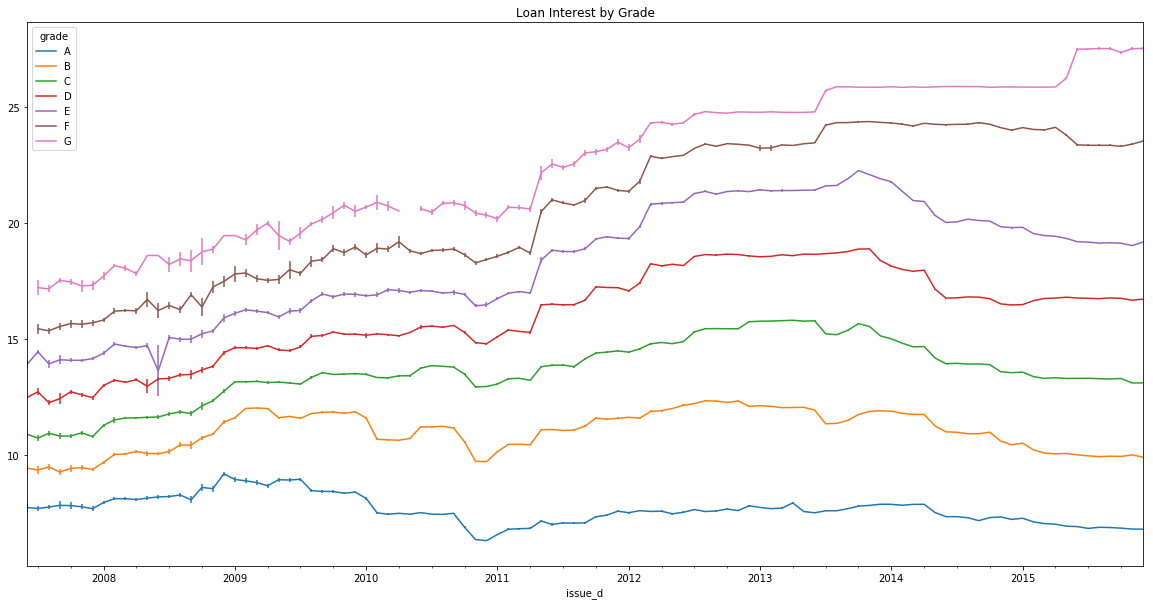

In [22]:
ByGradeInterestMeans = loansByGrade["int_rate"].agg(np.mean)
ByGradeInterestErrs = loansByGrade["int_rate"].agg(stats.sem)
unstackedByGradeInterestMeans = ByGradeInterestMeans.unstack(level=0)
unstackedByGradeInterestErrs = ByGradeInterestErrs.unstack(level=0)
unstackedByGradeInterestMeans.plot(yerr = unstackedByGradeInterestErrs, title = "Loan Interest by Grade", figsize = (20,10))
plt.savefig('LoanInterestByGradeTrended')

Looking at the above, we see that the variance in interest rates within loan grades gets eliminated over time. This may reflect issues with data quality at earlier points in the data set or LC trying different pricing structures before deciding on a consistent loan grading and pricing framework.

# Business Case

We are intersted in the rate of return of short-term (36 month) mature loans.  

To limit our data set, we apply a term filter and remove all loans whose origination date was less than 36 months from the end of the data set.  We assume that the data set contains complete information of each loan up until 12-2015, the last month during which loans were recorded.

In [23]:
shortTermLoans = df[df.term == " 36 months"]
shortTermLoans.shape

(621125, 53)

In [24]:
#limit to matured loans
print(max(shortTermLoans.issue_d))
print(shortTermLoans.loan_status.unique())

shortTermLoans = shortTermLoans[shortTermLoans.issue_d < '2012-12-01']
print(max(shortTermLoans.issue_d))
print(min(shortTermLoans.issue_d))
print(shortTermLoans.loan_status.unique())
shortTermLoans.shape

2015-12-01 00:00:00
['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Current'
 'Late (31-120 days)' 'In Grace Period' 'Late (16-30 days)' 'Default'
 'Issued']
2012-11-01 00:00:00
2007-06-01 00:00:00
['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Late (31-120 days)'
 'Default' 'Late (16-30 days)']


(70200, 53)

The average rate of return across 36 month loans is  0.08228763320195281


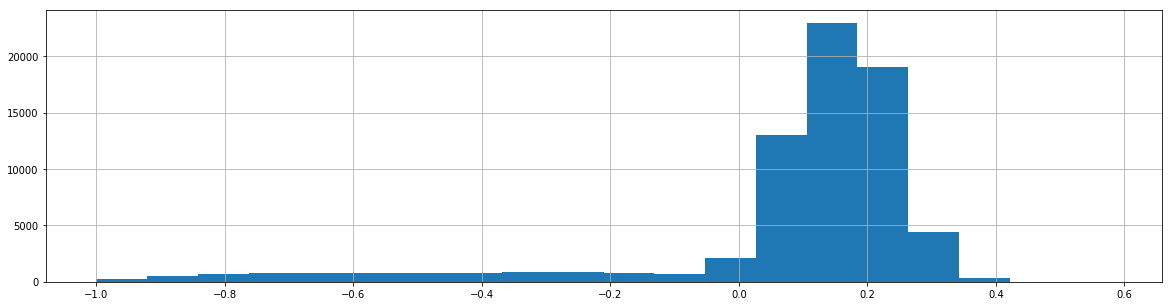

In [25]:
#Rate of Return = [(total_pymnt) - (loan_amnt)]/(loan_amnt)
#Rate of Return = [(total_pymnt_inv) - (funded_amnt_inv)]/(funded_amnt_inv)
shortTermLoans['RoR'] = (shortTermLoans['total_pymnt'] - shortTermLoans['loan_amnt'])/shortTermLoans['loan_amnt']
shortTermLoans["RoR"].hist(bins=20, figsize = (20,5))

print ("The average rate of return across 36 month loans is ", shortTermLoans.RoR.mean())

In [26]:
shortTermLoans['Year'] = shortTermLoans['issue_d'].map(lambda x: x.year)

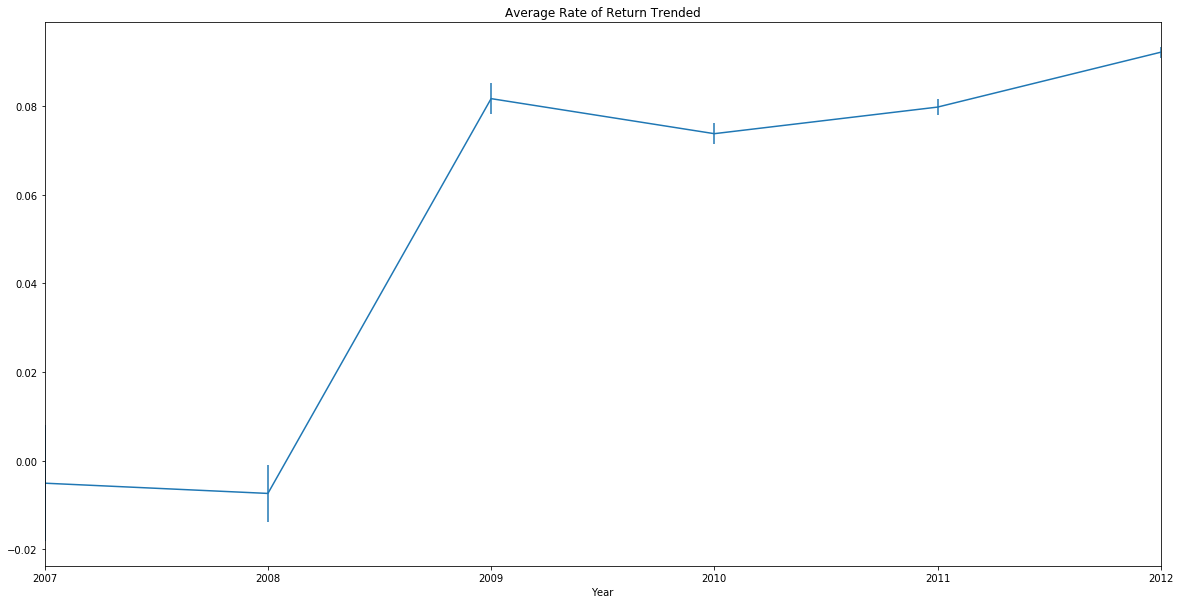

In [27]:
LoansByYear = shortTermLoans.groupby("Year")
RoRMeans = LoansByYear["RoR"].agg(np.mean)
RoRErrs = LoansByYear["RoR"].agg(stats.sem)
RoRMeans.plot(yerr=RoRErrs, title = "Average Rate of Return Trended", figsize = (20,10))
plt.savefig('AvgRoRTrended')

In [28]:
ror_crosstab = pd.crosstab(shortTermLoans['Year'],shortTermLoans['grade'], values = shortTermLoans.RoR, aggfunc = np.mean)
ror_crosstab

grade,A,B,C,D,E,F,G
Year,,,,,,,
2007,0.085993,0.019732,0.011286,-0.006195,-0.004286,-0.157170,-0.117222
2008,0.039563,-0.026048,-0.016491,-0.016463,0.021559,-0.059679,0.023882
2009,0.078966,0.079908,0.082853,0.093606,0.070446,0.065986,0.078067
2010,0.034258,0.081073,0.101821,0.090106,0.087093,0.058548,0.062956
2011,0.056388,0.090305,0.093580,0.109068,0.124279,0.122680,0.021205
2012,0.061558,0.095325,0.102123,0.118495,0.152374,0.157530,0.187839


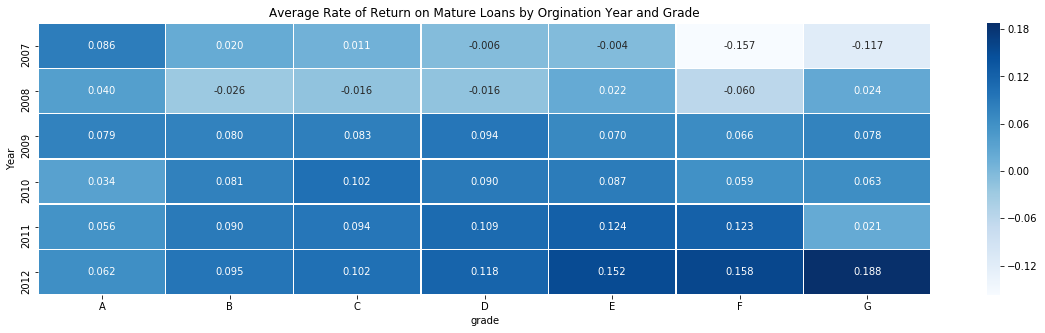

In [29]:
plt.figure(figsize = (20,5))
ror_crosstab_fig = sns.heatmap(ror_crosstab, annot = True,  fmt = ".3f", linewidths=.5, cmap="Blues")
plt.title("Average Rate of Return on Mature Loans by Orgination Year and Grade")
plt.savefig('RoRCrosstab')

The most profitable loans were G Grade loans originating in 2012.

While they do represent the most profitable loan grade on average, G loans do not have consistence performance across years and also have the highest variability in return as shown below.

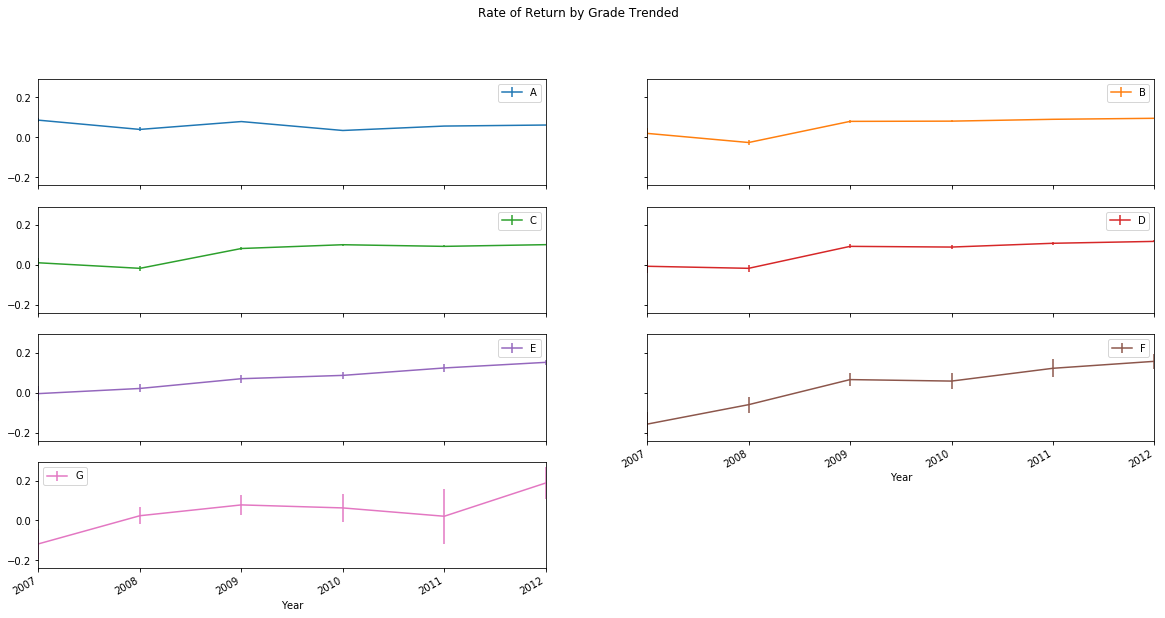

In [30]:
loansByGrade = shortTermLoans.groupby(["grade","Year"])
LoanMeans = loansByGrade["RoR"].agg(np.mean)
LoanErrs = loansByGrade["RoR"].agg(stats.sem)

unstackedLoanMeans = LoanMeans.unstack(level=0)
unstackedLoanErrs = LoanErrs.unstack(level=0)
unstackedLoanMeans.plot(yerr = unstackedLoanErrs, title = "Rate of Return by Grade Trended", subplots = True, figsize = (20,10), layout = (4,2), sharey = True)

plt.savefig('RoRByGradeTrended')

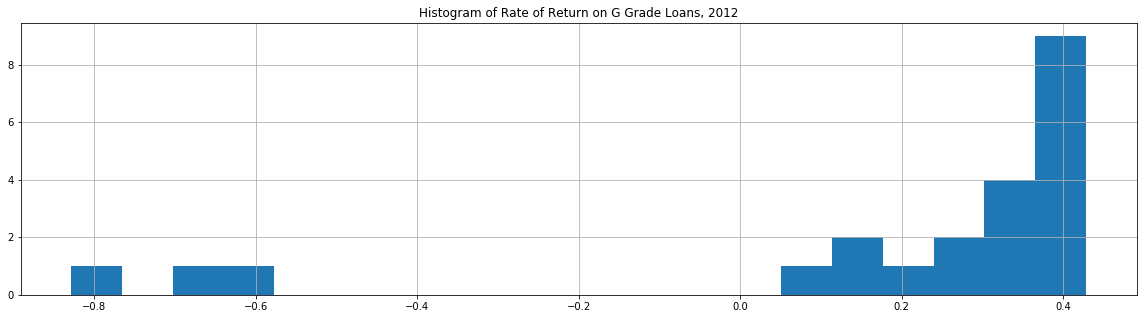

In [31]:
GshortTermLoans = shortTermLoans[(shortTermLoans.grade == "G") & (shortTermLoans.Year == 2012)]
GshortTermLoans["RoR"].hist(bins=20, figsize = (20,5))
plt.title("Histogram of Rate of Return on G Grade Loans, 2012")
plt.savefig('RoR_G2012_Hist')

# Part 3 Modeling

## Preparing the Data for Modeling

We prepare the data for modeling by removing variable that are either not revelant or would not be known at the time of origination.  Additionally, we need to remove or fill in all null vaules.

In [32]:
shortTermLoans.isnull().sum()

member_id                          0
loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_title                       4548
emp_length                         0
home_ownership                     0
annual_inc                         4
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
title                              9
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                       29
earliest_cr_line                  29
inq_last_6mths                    29
mths_since_last_delinq         43987
mths_since_last_record         66174
o

In [33]:
shortTermLoans.drop('member_id',1,inplace=True)
shortTermLoans.drop('Year',1,inplace=True)
shortTermLoans.drop('emp_title',1,inplace=True)
shortTermLoans.drop('issue_d',1,inplace=True)
shortTermLoans.drop('pymnt_plan',1,inplace=True)
shortTermLoans.drop('loan_status',1,inplace=True)
shortTermLoans.drop('title',1,inplace=True)
shortTermLoans.drop('zip_code',1,inplace=True)
shortTermLoans.drop('addr_state',1,inplace=True)
shortTermLoans.drop('out_prncp',1,inplace=True)
shortTermLoans.drop('out_prncp_inv',1,inplace=True)
shortTermLoans.drop('total_pymnt',1,inplace=True)
shortTermLoans.drop('total_pymnt_inv',1,inplace=True)
shortTermLoans.drop('total_rec_prncp',1,inplace=True)
shortTermLoans.drop('total_rec_int',1,inplace=True)
shortTermLoans.drop('total_rec_late_fee',1,inplace=True)
shortTermLoans.drop('recoveries',1,inplace=True)
shortTermLoans.drop('collection_recovery_fee',1,inplace=True)
shortTermLoans.drop('last_pymnt_d',1,inplace=True)
shortTermLoans.drop('last_pymnt_amnt',1,inplace=True)
shortTermLoans.drop('next_pymnt_d',1,inplace=True)
shortTermLoans.drop('last_credit_pull_d',1,inplace=True)
shortTermLoans.drop('earliest_cr_line',1,inplace=True)
shortTermLoans.drop('application_type',1,inplace=True)
shortTermLoans.drop('term',1,inplace=True)

#highly correlated with loan_amnt
shortTermLoans.drop('funded_amnt',1,inplace=True)
shortTermLoans.drop('funded_amnt_inv',1,inplace=True)

In [34]:
shortTermLoans.dtypes

loan_amnt                       float64
int_rate                        float64
installment                     float64
grade                          category
sub_grade                      category
emp_length                       object
home_ownership                   object
annual_inc                      float64
verification_status              object
purpose                          object
dti                             float64
delinq_2yrs                     float64
inq_last_6mths                  float64
mths_since_last_delinq          float64
mths_since_last_record          float64
open_acc                        float64
pub_rec                         float64
revol_bal                       float64
revol_util                      float64
total_acc                       float64
initial_list_status              object
collections_12_mths_ex_med      float64
mths_since_last_major_derog     float64
acc_now_delinq                  float64
tot_coll_amt                    float64


In the interest of time and simplicity, we will ignore categorical variables for the sake of this analysis. Categorical variables may be highly relevant to the model however, they would also require significant cleaning and would introduce computing complexity.

In [35]:
shortTermLoans_numeric = shortTermLoans.select_dtypes(include=['float64','int64'],exclude=['object','category'])
shortTermLoans_numeric = shortTermLoans_numeric.fillna(0)
shortTermLoans_numeric.isnull().sum()

loan_amnt                      0
int_rate                       0
installment                    0
annual_inc                     0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
mths_since_last_delinq         0
mths_since_last_record         0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
total_acc                      0
collections_12_mths_ex_med     0
mths_since_last_major_derog    0
acc_now_delinq                 0
tot_coll_amt                   0
tot_cur_bal                    0
total_rev_hi_lim               0
RoR                            0
dtype: int64

In [36]:
shortTermLoans_numeric.dtypes

loan_amnt                      float64
int_rate                       float64
installment                    float64
annual_inc                     float64
dti                            float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
total_rev_hi_lim               float64
RoR                            float64
dtype: object

In [37]:
shortTermLoans_numeric.shape

(70200, 21)

We can to construct a model that predicts the rate of return using the input columns in the data above.

We are also going to remap the rate of return column to a few bins so that we can map ranges of output values to colors:

In [38]:
X,y = shortTermLoans_numeric.ix[:,:7],shortTermLoans_numeric.ix[:,-1]
feature_names = X.columns.tolist()
target_name = shortTermLoans_numeric.columns.tolist()[-1]
shortTermLoans_numeric["RoR_bins"] = pd.cut(shortTermLoans_numeric[target_name],5) #create 5 equally-sized bins

Let's visualize out inputs and output in a scatter matrix to get a feel for our data:

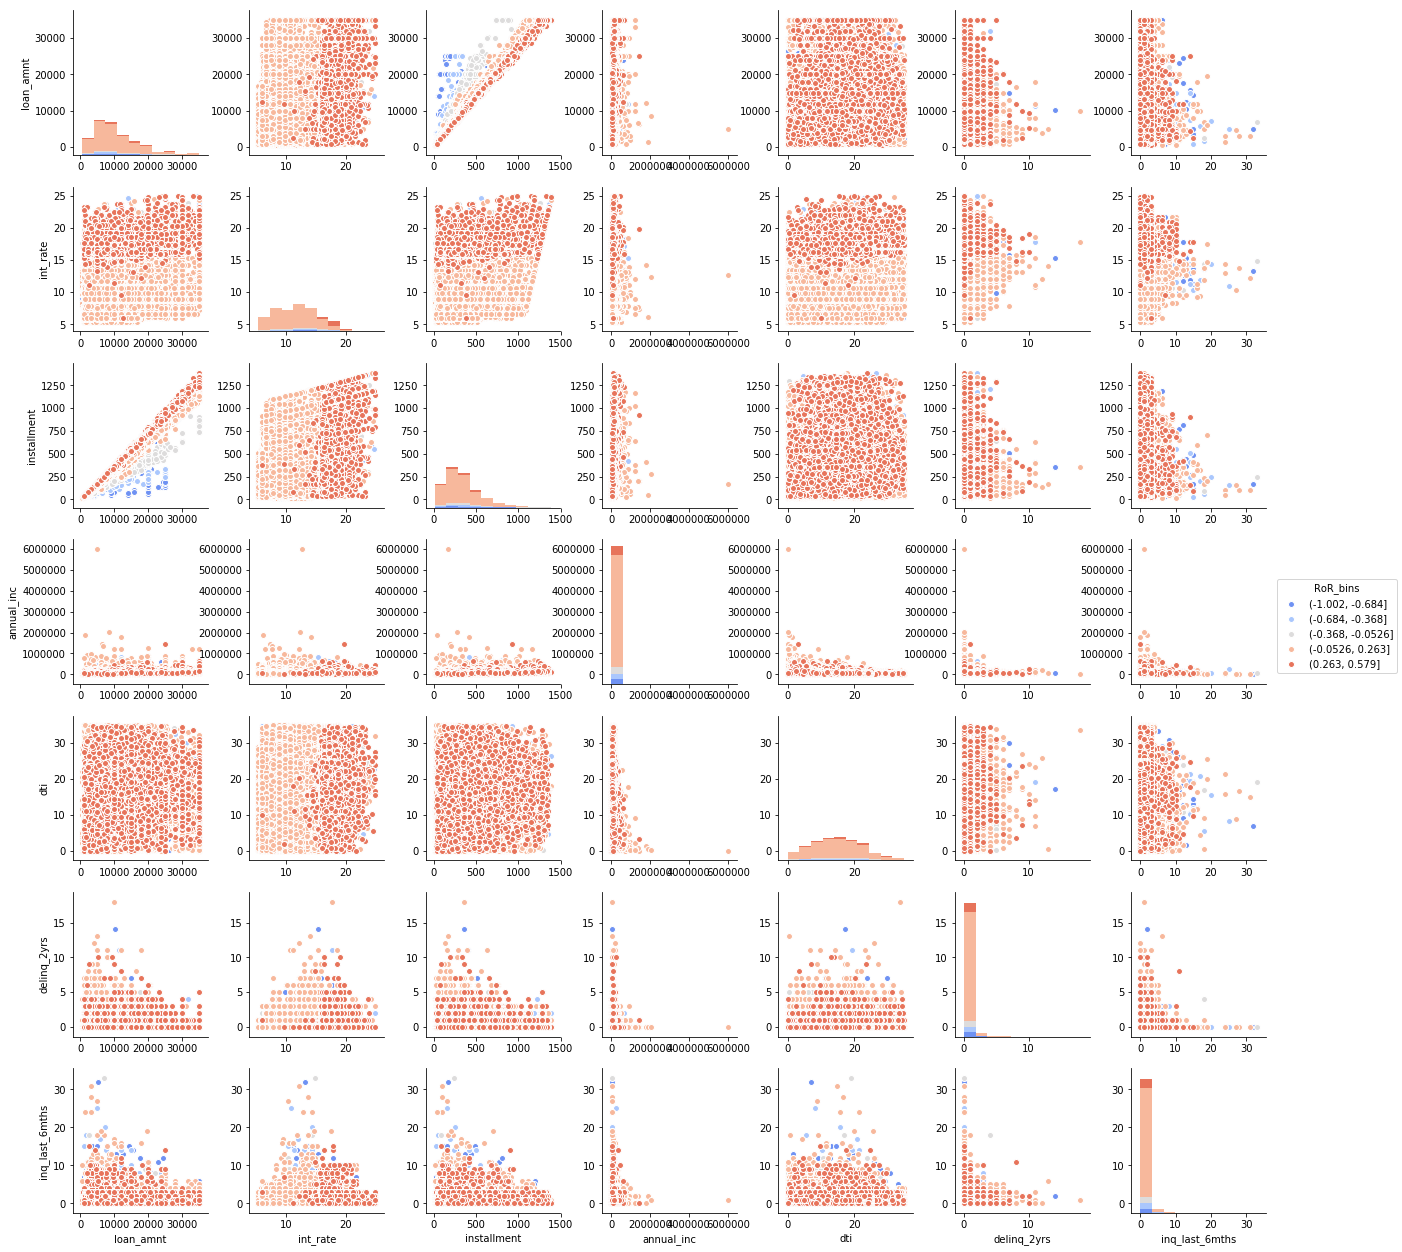

In [39]:
sns.pairplot(shortTermLoans_numeric[feature_names+['RoR_bins']],hue="RoR_bins", palette='coolwarm')
plt.savefig('PairWisePlot')

Let's now generate train/test splits of our data

In [40]:
X,y = shortTermLoans_numeric.ix[:,:20],shortTermLoans_numeric.ix[:,-2]
feature_names = X.columns.tolist()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=20)

In [41]:
X_train.dtypes

loan_amnt                      float64
int_rate                       float64
installment                    float64
annual_inc                     float64
dti                            float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
total_rev_hi_lim               float64
dtype: object

Also for reference, we need to calculate the average Rate of Return of all 36 month loans.  This tells us the RoR we need to "beat" with our models.

In [42]:
shortTermLoans_numeric.RoR.mean()

0.08228763320195281

## Simple Decision Tree Model

Now let's generate a simple Decision Tree model to predict Rate of Return of our loans:

In [43]:
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(X_train,y_train)
print ("Decision Tree RMSE:",np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test))))

Decision Tree RMSE: 0.23708295435


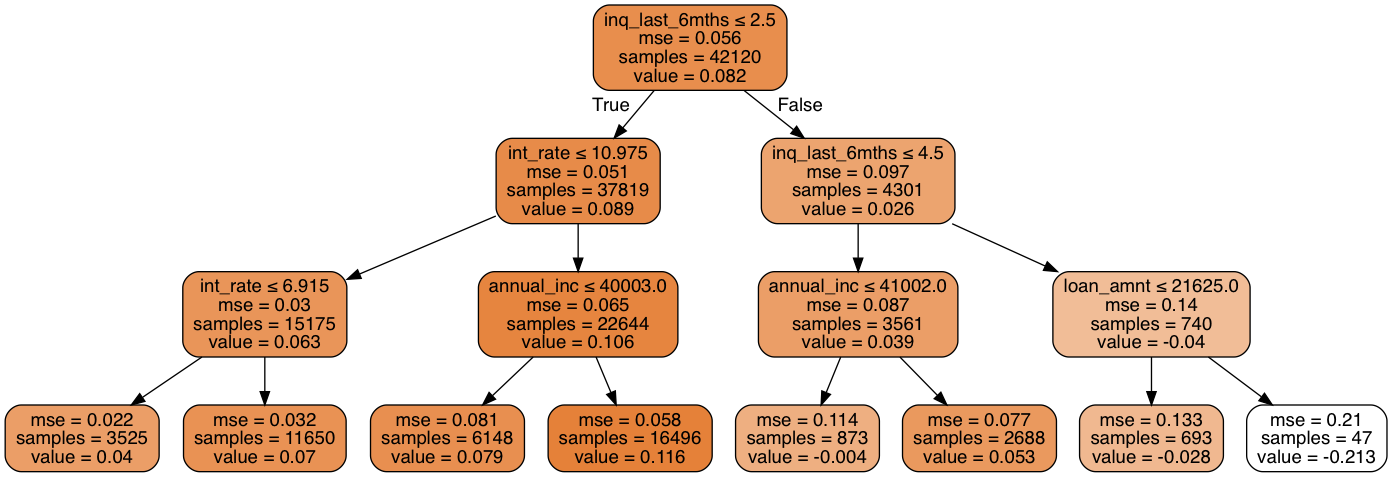

In [44]:
#This code allows us to make a decision tree directly in the notebook-
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

The code below measures the optimal depth of our decision tree:

Decision Tree Train/Test RMSE: 0.23632886468   0.238171473758
Decision Tree Train/Test RMSE: 0.235317139969   0.237426106843
Decision Tree Train/Test RMSE: 0.234700576737   0.23708295435
Decision Tree Train/Test RMSE: 0.234099211001   0.237159665215
Decision Tree Train/Test RMSE: 0.233077394677   0.236897602014
Decision Tree Train/Test RMSE: 0.231880938712   0.237795843583
Decision Tree Train/Test RMSE: 0.230312411601   0.238774105183
Decision Tree Train/Test RMSE: 0.228233687345   0.241625172144
Decision Tree Train/Test RMSE: 0.226029646914   0.24316770828
Decision Tree Train/Test RMSE: 0.223066865342   0.245152912698


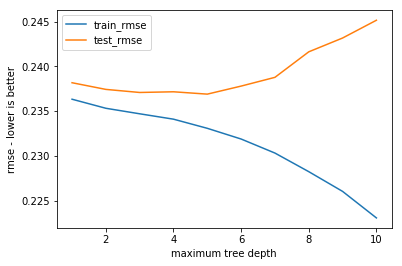

In [45]:
depths = range(1,11)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print ("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
plt.plot(depths,train_rmse,label='train_rmse')
plt.plot(depths,test_rmse,label='test_rmse')
plt.xlabel("maximum tree depth")
plt.ylabel("rmse - lower is better")
plt.legend()

In [46]:
# max_depth=5 was best, so fit a tree using that parameter
best_single_tree = DecisionTreeRegressor(max_depth=5, random_state=1)
best_single_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [47]:
pd.DataFrame({'feature':feature_names, 'importance':best_single_tree.feature_importances_})

,feature,importance
0,loan_amnt,0.051309
1,int_rate,0.260712
2,installment,0.067204
3,annual_inc,0.187988
4,dti,0.029895
5,delinq_2yrs,0.000000
6,inq_last_6mths,0.241417
7,mths_since_last_delinq,0.000000
8,mths_since_last_record,0.022832
9,open_acc,0.000000


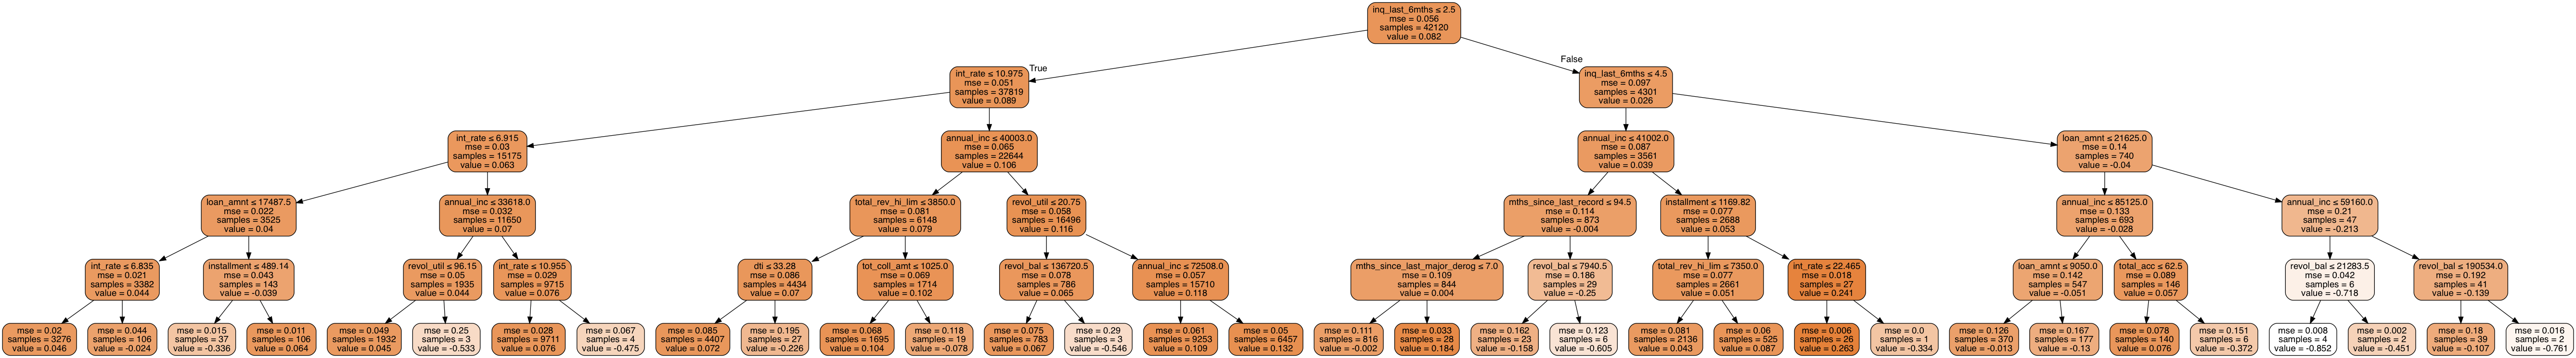

In [56]:
dot_data2 = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data2,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph_best = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph_best.create_png())

In [62]:
graph_best.write_png('Tree.png')

True

In [49]:
# use fitted model to make predictions on testing data
y_pred_single = best_single_tree.predict(X_test)
y_pred_single

array([ 0.10890788,  0.10890788,  0.04490292, ...,  0.10389802,
        0.07592173,  0.10890788])

In [50]:
# calculate test set RMSE
np.sqrt(mean_squared_error(y_test, y_pred_single))

0.2368976020141467

## Bagged Regression Tree (b=10)

The primary weakness of decision trees is that they don't tend to have the best predictive accuracy. This is partially due to high variance, meaning that different splits in the training data can lead to very different trees.

With bagging (short for bootstrap aggregation), we can grow b trees using b bootstrapped samples from the training data, train each tree on its sample, and finally, combine the predictions.

Bagging increases the predictive accuracy of the model by reducing the variance in training splits.

In [51]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1234)
# fit and predict
bagreg.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)
y_pred_bag

array([ 0.13618923,  0.12460016,  0.04175657, ...,  0.11550884,
        0.04994964,  0.10250547])

In [52]:
# calculate RMSE
print ("Bagged RMSE with 500 trees:",np.sqrt(mean_squared_error(y_test, y_pred_bag)))

Bagged RMSE with 500 trees: 0.238932774389


## Random Forests

Random forests are just a slight variation of bagged trees that have even better performance.  Just like bagging, we create an ensemble of descision trees however, when building each tree, we also select a random sample of features as split candidates.

Why is this better? Lets suppose there is one very predictive feature in the data set. When using bagged trees, most of the trees will use that feature at the top split, resulting in an ensemble of trees that are highly correlated. Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging). By randomly leaving out candidate features from each split, Random Forests "decorrelate" the trees, such that the averaging process reduces the variance of the resulting model.

In [53]:
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [54]:
print ("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

Random Forest RMSE: 0.238856999843


## Conclusion & All the models together

In [55]:
print ("Single Tree RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_single)))
print ("Bag RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_bag)))
print ("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

Single Tree RMSE: 0.236897602014
Bag RMSE: 0.238932774389
Random Forest RMSE: 0.238856999843


In this case, the single tree is more effective than its aggregated/bootstapped counterparts. This indicates that the single tree model does not suffer from instability, the risk we were trying to control for with more complicated methods.

In terms of interpretability and being business-friendly, this is a great scenario as the single tree model is very easy to understand and execute upon.



With these findings, we can improve the average rate of return from 8.2% to at most 24.1%, depending on our risk appetite and desired returns.